In [145]:
import numpy as np
import scipy
from sympy import Symbol, Integer, Piecewise, Catalan, N, Min, Sum, lambdify, pi, sqrt, exp, log, acos, asin, besselk
from fractions import Fraction
import matplotlib.pyplot as plt
import sys
from IPython.display import display

# Outline

We follow the outline of the paper:

  - In Section 3 we treat the truncated Coulomb case, giving details on the proof of Proposition 3.8 and the code to produce Figure 1.
  - In Section 4 we treat the Yukawa case, detailing the proof of Lemma 4.6 and the code to produce Figures 2 and 3.

# 3. Truncated Coulomb potential

## Proof of Proposition 3.8

We check that  the fact $e^{3,\mathrm{ball}}_{R_{1,\kappa}}<e^{3,\mathrm{cyl}}_{R_{1,\kappa}}$ for $\kappa=11/10$ using symbolic computation (SymPy library).

First, we define
$$
f_{1,11/10}(\lambda) = \frac{60}{11}\lambda + 6\pi\left(\frac{11}{10}\right)^{2}
\left( \frac{\lambda^3}{15} -\frac{\lambda}{3}+\dfrac1{3}\right)
$$
as in eq. (34) in the proof of Proposition 3.8.

In [2]:
kappa = Fraction("11/10")

x = Symbol('x')
sigma_K_11_10_sympy = lambda x: Fraction("60/11")*x+6*pi*Fraction("11/10")**2*(Fraction("1/3")+x**3*Fraction("1/15")-x*Fraction("1/3"))
sigma_K_11_10_numpy = lambdify(x, sigma_K_11_10_sympy(x), 'numpy')

Then we define
$$
\lambda_{*,11/10,1}
= \left[\frac{5}{\pi}\left(\frac{\pi}{3}-\left(\frac{10}{11}\right)^3\right)\right]^{1/2}
$$
and
$$
\rho^{3,\mathrm{ball}}_{R_{1,11/10}}=\sigma_{1,11/10}(\lambda_{*,11/10,1})
$$

In [3]:
lmbstar = sqrt(5/pi*(pi*Fraction("1/3")-Fraction("10/11")**3))
rho_ball = sigma_K_11_10_sympy(lmbstar)

An upper bound of $\rho^{3,\mathrm{cyl}}_{R_{1,11/10}}$ is
$$
\sigma^{3,\mathrm{cyl}}_{R_{1,11/10}}(11/20) = \frac{40}{11}+\left(\frac{11}{5}\right)^2\left(\frac{\pi}{2} -\frac{17}{12} +\frac{C}{2}\right)
$$
where $C$ is the Catalan constant (see Lemma 3.5).

In [4]:
rho_cyl_upper_bound = Fraction("40/11")+Fraction("11/5")**2*(pi*Fraction("1/2")-Fraction("17/12")+Catalan*Fraction("1/2"))

Finally, we ask SymPy the truth value of $\sigma^{3,\mathrm{cyl}}_{R_{1,11/10}}(11/20) < \rho^{3,\mathrm{ball}}_{R_{1,11/10}}$. SymPy evaluates the expressions with a accuracy which is sufficient for determining the truth value of the comparison.

In [5]:
print("For kappa=", kappa, "we find:\n")
print('rho^ball=', end=" ")
display(rho_ball)
print()
print("rho^{cyl}< sigma(kappa/2)= ")
display(rho_cyl_upper_bound)
print("(G is the Catalan number C)\n")

print('For the assertion rho^cyl < sigma(kappa/2), sympy returns: ', rho_cyl_upper_bound < rho_ball)

print()
print('The 10 first digits in the decimal representation are:')
print('rho^ball  ~= ', rho_ball.evalf(n=10, strict=True))
print("sigma(kappa/2) ~=", rho_cyl_upper_bound.evalf(n=10, strict=True))

For kappa= 11/10 we find:

rho^ball= 

363*pi*(-sqrt(5)*sqrt(-1000/1331 + pi/3)/(3*sqrt(pi)) + sqrt(5)*(-1000/1331 + pi/3)**(3/2)/(3*pi**(3/2)) + 1/3)/50 + 60*sqrt(5)*sqrt(-1000/1331 + pi/3)/(11*sqrt(pi))


rho^{cyl}< sigma(kappa/2)= 


-10627/3300 + 121*Catalan/50 + 121*pi/50

(G is the Catalan number C)

For the assertion rho^cyl < sigma(kappa/2), sympy returns:  True

The 10 first digits in the decimal representation are:
rho^ball  ~=  6.619922674
sigma(kappa/2) ~= 6.598987929


## Producing Figure 1

## Computation of $\rho^{3,\mathrm{ball}}_{R_{1,\kappa}}$

The function `rho_ball_tC` below computes $\rho^{3,\mathrm{ball}}_{R_{1,\kappa}}$ for a given $\kappa$, according to Proposition 3.3.

In [6]:
def rho_ball_tC(K):
    r''' Computes e^{3,ball}_{R_{1,K}}, for a fixed K, to machine precision.
         See Proposition 3.3.
       
         Returns (val_opt, r_opt), where
         val_opt: the computed minimum
         r_opt: the computer minimizer
    '''

    Kmin = (3/np.pi)**(1/3)
    Kmax = (15/(2*np.pi))**(1/3)
    riesz_ball_dim3 = 32/15*np.pi**2
    
    f = lambda l : 6*l/K+6*np.pi*K**2*(l**3/15-l/3+1/3)
    if K <= Kmin:
        return (f(0),np.inf)
    elif K >= Kmax:
        r_opt = (4*np.pi/(2*riesz_ball_dim3))**(1/3)
        return (3*3/(2*r_opt), r_opt)
    else:
        l_star = np.sqrt(5/np.pi*(np.pi/3-1/K**3))
        return (f(l_star),K/(2*l_star))


We define `sigma_cyl_tC` below which computes $\sigma^{3,\mathrm{cyl}}_{R_{1,\kappa}}(l)$ given $\kappa$ and $l$, following Proposition 3.4. It uses Simpson's quadrature formula to compute the integral in equation (23) of the paper. This function is only used to produce Figure 1, that is, to illustrate that $\rho^{3,\mathrm{ball}}_{R_{1,\kappa}}<\rho^{3,\mathrm{cyl}}_{R_{1,\kappa}}$ likely holds for an interval around $\kappa=11/10$.

We also introduce the auxiliary functions
  - `xlogx(x) = x*log(x)` which is stable for small values of $x$ and returns $0$ for $x=0$
  - `log1p(x= log(1+x)` which is accurate also for x so small that `1 + x == 1` in floating-point accuracy.
  - `quad_simpson(f,a,b,n)` which uses Simpson's quadrature formula with `n` subintervals to estimate $\int_a^b f(t)\,dt$

In [212]:
xlogx = lambda x : scipy.special.xlogy(x,x)
log1p = np.log1p

def quad_simpson(f,a,b,n):
    r""" Compute \int_a^b f using Simpson quadrature method with n subintervals."""
    
    h = (b-a)/n
    X = np.linspace(a,b,n+1)
    fX = np.array([f(x) for x in X])
    Xmil = (X[:-1]+X[1:])/2
    fXmil = np.array([f(x) for x in Xmil]) # we can use fXmil = f(Xmil) if f accepts numpy arrays
    
    return h/6*(fX[1:]+fX[:-1]+4*fXmil).sum()

def sigma_cyl_tC(K,l,quad_method="simpson", N=2**6):
    r''' Computes f_{R_{1,K}}^{3,cyl}(l) given K and l, i.e. the energy-per-mass
         of the infinite cylinder of radius l, for the truncated Coulomb potential.
    
         It involves numerical evaluation of a 1D integral.
        
         quad_method: quadrature method to be used, which can be specified to "simpson".
         N: number of sub_intervals used when quad_method is simpson
        
         If quad_method in not "simpson", scipy default quadrature method is used.
    '''
    
    lmbd = K/(2*l)
    
    if quad_method == "simpson":
        quad_func = lambda f,a,b: quad_simpson(f,a,b,N)
    else:
        quad_func = lambda f,a,b: scipy.integrate.quad(f,a,b)[0]
        
    def g(ell):
        # Notice x^3 arctanh(sqrt(1-x^2)) = x^3*log(1+sqrt(1-x^2))-x**3*log(x)
        # Using the functions np.log1p(x)=log(1+x) and scipy.special.xlogy(x,x)=x*log(x),
        # we have an expression which is stable even for small x.
        if ell<1:
            return 4*np.pi/3*(ell-np.arcsin(ell)+2*ell*(1-np.sqrt(1-ell**2))+ell**3*log1p(np.sqrt(1-ell**2))-ell**2*xlogx(ell))
        else:
            return 4*np.pi*(ell-np.pi/6)
    
    integrand1 = lambda r: g(np.sqrt(1-r**2)/lmbd)
    integrand2 = lambda r: g(np.sqrt(l**2-r**2)*2/K)
    
    if lmbd == 1:
        I_cyl_tC = K**4*np.pi*(np.pi/2-17/12+1/2*float(sympy.Catalan))
    elif lmbd > 1:
        I_cyl_tC = 2*K**2*l**2*lmbd*quad_func(integrand1,0,1)
    else:
        I_cyl_tC = 2*K**2*l**2*lmbd*quad_func(integrand1,0,lmbd)+K**3*quad_func(integrand2,K/2,l)

    return 2/l+I_cyl_tC/(np.pi*l**2)


Below, we plot $\rho^{3,\mathrm{ball}}_{R_{1,\kappa}}$ and an upper bound of $\rho^{3,\mathrm{cyl}}_{R_{1,\kappa}}$ for varying $\kappa$. An upper bound is obtained by computing $\sigma^{3,\mathrm{cyl}}_{R_{1,\kappa}}(l(\kappa))$ for an adequate $l(\kappa)$. We use SciPy's optimization tools to find an adequate $l(\kappa)$.

In [8]:
# Plot rho^{ball}_{R_{1,K}} and Plot rho^{cyl}_{R_{1,K}} for a range of K

nK = 70
vK = np.linspace(0.96,1.15,nK)

l_cyl_hint = 1./2
vrho_ball = np.zeros_like(vK)
vrho_cyl = np.zeros_like(vK)
i = nK-1
while True:
    K = vK[i]
    
    vrho_ball[i], r_ball_opt = rho_ball_tC(K)
    
    res_opt = scipy.optimize.minimize(lambda l:  sigma_cyl_tC(K,l,quad_method="scipy"),
                                      l_cyl_hint, constraints=[scipy.optimize.LinearConstraint(np.ones(1), lb=0)])
    vrho_cyl[i] = res_opt.fun
    l_cyl_hint = res_opt.x[0]
    
    i -= 1
    if i < 0:
        break

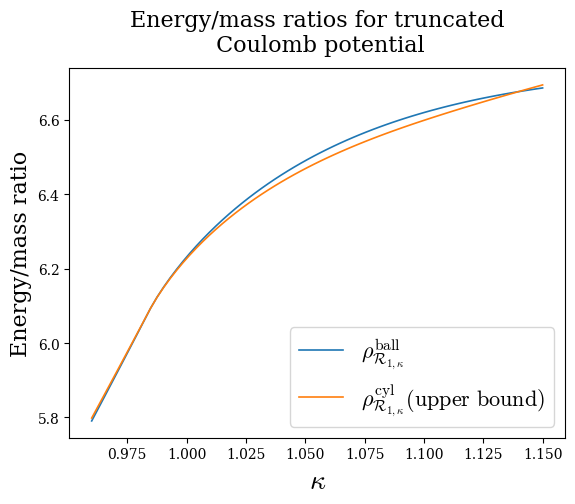

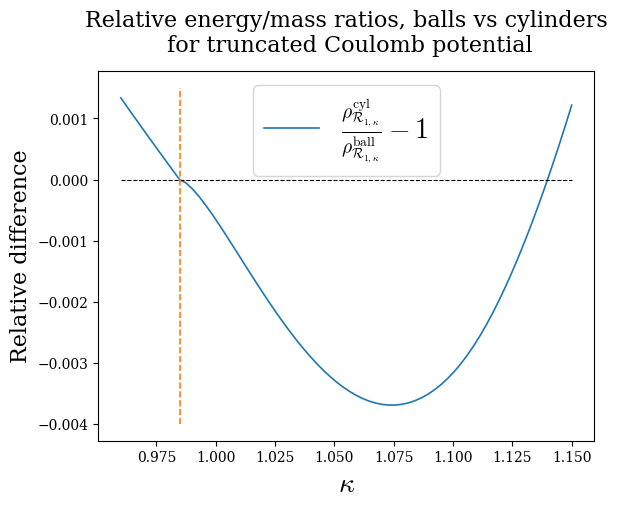

In [9]:
# Plot energy-per-mass
plt.figure(1)
plt.rcParams.update({'mathtext.fontset': "cm", "font.family": "serif"})
plt.plot(vK, vrho_ball, '-', linewidth=1.2,label='$\\rho^{\\mathrm{ball}}_{\\mathcal{R}_{1,\\kappa}}$')
plt.plot(vK, vrho_cyl, '-',linewidth=1.2,label='$\\rho^{\\mathrm{cyl}}_{\\mathcal{R}_{1,\\kappa}} \\mathrm{(upper~bound)}$')
plt.title("Energy/mass ratios for truncated\n Coulomb potential", fontsize=16, pad=12)
plt.xlabel("$\\kappa$",fontsize=20)
plt.ylabel("Energy/mass ratio", fontsize=16)
plt.legend(loc="lower right", fontsize=16)
plt.savefig("energy-per-mass_trunc_coulomb.pdf",bbox_inches='tight')

plt.show()

# Plot relative improvement
plt.figure()
plt.plot(vK, vrho_cyl/vrho_ball-1, '-', linewidth=1.2, 
         label="$\\frac{\\rho^{\\mathrm{cyl}}_{\\mathcal{R}_{1,\\kappa}}}{\\rho^{\\mathrm{ball}}_{\\mathcal{R}_{1,\\kappa}}}-1$")
plt.plot(vK, np.zeros_like(vK), 'k', linewidth=0.8, linestyle="dashed" )
Kmin = (3/np.pi)**(1/3)
vy = np.linspace(-4e-3,1.5e-3,100)
plt.plot(np.full_like(vy,Kmin), vy, linewidth=1.2, linestyle="dashed")

plt.title("Relative energy/mass ratios, balls vs cylinders\n for truncated Coulomb potential", fontsize=16 ,pad=14)
plt.xlabel("$\\kappa$", fontsize=20, math_fontfamily='cm')
plt.ylabel("Relative difference",fontsize=16)
plt.legend(fontsize=20,loc='upper center')

plt.savefig("relative_diff_trunc_coulomb.pdf",bbox_inches='tight')
plt.show()

# 4. Yukawa potential

This section is related to the proof of Lemma 4.6 as well as Figures 2 and 3.

## Proof of Lemma 4.6

We want to establish
$$
\rho^{3,\mathrm{cyl}}_{1,0.56} < \rho^{3,\mathrm{ball}}_{1,0.56}.
$$

First, we set $\kappa=0.56$.

In [10]:
kappa = Fraction("0.56")

### Estimation of $\rho^{3,\mathrm{ball}}_{Y_{1,0.56}}$ from below

According to Proposition 4.4, we have
$$
\rho^{3,\mathrm{ball}}_{Y_{1,\kappa}} = \inf f_{\kappa}(l)
$$
where
$$
f_\kappa(l)= \frac{6l}{K}+4\pi K^2(1-3l(1-4l^2)-3l(4l^2+4l+1)e^{-1/l}
$$

We first look for an approximation of the minimizer $l_{\mathrm{opt}}(\kappa)$.

For this, we define the functions $f_\kappa$, $f_\kappa'$ and $f_\kappa''$, as in the proof of Proposition 4.4.

For numerical computations only, we introduce the auxiliary function:
  - `invx_p_exp_minvx(x)` which computes $\frac{e^{-1/x}}{x^p}$ in a stable way even for small and large values of $x$


In [11]:
# Definition of f_K, f_K' and f_K'', working with sympy (symbolic) and numpy (numeric).

# Definition of f_K, f_K' and f_K'', working with sympy (symbolic) or numpy (numeric).
fK_sympy = lambda K,l : 6*l/K+4*pi*K**2*(1-3*l*(1-4*l**2)-3*l*exp(-1/l)*(4*l**2+4*l+1))
fK_p_sympy = lambda K,l : 6/K-12*pi*K**2*(1-12*l**2+exp(-1/l)/l*(12*l**3+12*l**2+5*l+1))
fK_pp_sympy = lambda K,l : 12*pi*K**2*(24*l-exp(-1/l)/l**3*(24*l**4+24*l**3+12*l**2+4*l+1))

# We don't use lambdify because sympy would automatically replace exp(-1/x-p*log(x)) by e^{-1/x}/x^p,
# which is not numerically stable for x small.
def invx_p_exp_m_invx(p,x):
    """ Compute e^{-1/t} / t^p if t > 0 and 0 otherwise, in a numerically stable way for t small or large.
        t : scalar
        p : exponent
    """
    if x <= 0:
        return 0.
    else:
        return np.exp(-1/x-p*np.log(x))

fK_numpy = lambda K,l : 6*l/K+4*np.pi*K**2*(1-3*l*(1-4*l**2)-3*l*invx_p_exp_m_invx(0,l)*(4*l**2+4*l+1))
fK_p_numpy = lambda K,l : 6/K-12*np.pi*K**2*(1-12*l**2+invx_p_exp_m_invx(1,l)*(12*l**3+12*l**2+5*l+1))
fK_pp_numpy = lambda K,l : 12*np.pi*K**2*(24*l-invx_p_exp_m_invx(3,l)*(24*l**4+24*l**3+12*l**2+4*l+1))

Then, we define the function `rho_ball_Y` which evaluates *numerically* $\rho^{3,\mathrm{ball}}_{1,\kappa}$ for a given $\kappa$. We use Newton method to find the unique zero of $f_K'$ to machine precision, when the minimizer belongs to $(0,+\infty)$.

This function is used to get a first estimate of $l_{\mathrm{opt}}(\kappa)$ for $\kappa=0.56$, and to produce Figure 3.

In [12]:
def newton(f,Df,x0,max_iter=200, armijo_improv=0.9):
    r""" Newton method to find a zero of f in (0,\infty), starting from x0."""
    x = x0
    value = f(x)
    i = 1
    while True:
        prev_x, prev_value = x, value
        d = -f(x)/Df(x)
        t = 1
        while True:
            x = prev_x+t*d
            # Once x is close to the minimizer, t=1 should work (Newton)
            # Before that, we reduce t as much as needed to decrease |f| by a given factor (armijo criterion)
            value = f(x)
            if x>=0 and np.abs(value) <= np.abs(prev_value)*0.9:
                break
            else:
                t /= 2
        i += 1
        
        if np.isclose(prev_x,x,atol=1e-18) or i >= max_iter:
            break
    return (x,i < max_iter)

def rho_ball_Y(K, use_scipy_optimizer=False):
    r''' Computes rho^{3,ball}_{Y_{1,K}}, for a fixed K, to machine precision.
         Setting f_K(l)= \frac{6l}{K}+4\pi K^2(1-3l(1-4l^2)-3l(4l^2+4l+1)rho^{-1/l} and l=K/(2R),
         
         If use_scipy_optimize is False (the default), we use Newton method to find the zero of f_K'.
         Otherwise, we use scipy optimizer as a black box.
         
         Returns (val_opt, r_opt, success), where
         val_opt: the computed minimum
         l_opt: the computed minimizer
         success: a boolean indicating if machine precision was reached
    '''

    if K <= (2*np.pi)**(-1/3):
        # The minimizer is 0, and the minimum is 4\pi^2
        return (4*np.pi*K**2, 0, True)

    # We use Newton method on fK_p
    R_init = 15/(16*np.pi)**(1/3) # We take the optimal radius in the classical Coulomb case as initial guess
    l_init = K/(2*R_init)
    
    if use_scipy_optimizer:
        # Scipy may use one of BFGS, L-BFGS-B, SLSQP method.
        res = scipy.optimize.minimize(lambda l: (fK_numpy(K,l), fK_p_numpy(K,l)),
                                      l_init,
                                      jac=True,
                                      tol=1e-18,
                                      constraints=[scipy.optimize.LinearConstraint(np.ones(1), lb=0)])
        return (res.fun, l_res.x[0], res.success)
    else:
        l_opt,success = newton(lambda l: fK_p_numpy(K,l), lambda l: fK_pp_numpy(K,l),l_init)
        
        return (fK_numpy(K,l_opt), l_opt, success)

We observe numerically that $l_{\mathrm{opt}}(0.56)\simeq 0.08848204538567361$:

In [13]:
rho_ball_opt, l_ball_opt, success = rho_ball_Y(np.float64(kappa))
assert success
print("l("+ f'{kappa:.2f}' + ") ~= " + f'{l_ball_opt}')

l(0.56) ~= 0.08848204538567361


We check with SympPy that $l_{\mathrm{opt}}(0.56) \in (\alpha,\beta)$, where $\alpha=8.84\times 10^{-2}$ and $\beta=\alpha+10^{-4}$, since $f_\kappa$ is stricly convex and

$$
f_\kappa'\alpha)f_\kappa'(\beta) < 0.
$$

In [14]:
alpha = Fraction('8.84e-2')
beta = alpha+Fraction('1e-4')

print("The assertion f_K'(alpha)*f_K'(beta)<0 is: ", fK_p_sympy(kappa,alpha)*fK_p_sympy(kappa,beta)<0)

The assertion f_K'(alpha)*f_K'(beta)<0 is:  True


By the convexity of $f_\kappa$, we have

$$
f_\kappa(l_{\mathrm{opt}}(\kappa)) \geq \min(T_\alpha(\beta),T_\beta(\beta))
$$

where $T_\alpha$ and $T_\beta$ are respectively the tangent lines of $f_\kappa$ at $\alpha$ and $\beta$.

Below, we ask SymPy to evaluate this minimum to a precision of $10^{-10}$, to get the lower bound

$$
\rho^{3,\mathrm{ball}}_{1,0.56} \geq 3.875503068.
$$

In [15]:
Talpha = lambda x : fK_sympy(kappa,alpha)+fK_p_sympy(kappa,alpha)*(x-alpha)
Tbeta = lambda x : fK_sympy(kappa,beta)+fK_p_sympy(kappa,beta)*(x-beta)

eball_Y_lbound = Min(Talpha(beta),Tbeta(alpha))

print("By SymPy, we have\n")
print("rho_ball >= ")
display(eball_Y_lbound)
print(">=", N(eball_Y_lbound,10,strict=True))


By SymPy, we have

rho_ball >= 


-147*pi*(6031501583*exp(-2500/221)/345312500 + 1415977/1562500)/390625 + 531/560 + 784*pi*(2902694083/3906250000 - 1434626583*exp(-2500/221)/3906250000)/625

>= 3.875503068


### Estimation of $\rho^{3,\mathrm{cyl}}_{Y_{1,0.56}}$ from above

By definition of $\rho^{3,\mathrm{cyl}}_{Y_{1,0.56}}$, we have
$$
\rho^{3,\mathrm{cyl}}_{Y_{1,0.56}} \leq \sigma^{3,\mathrm{cyl}}_{Y_{1,0.56}}(l)
$$
for any $l$.
By Proposition 4.5, we have
$$
\sigma^{3,\mathrm{cyl}}_{Y_{1,0.56}}(l) = \frac{2}{l}+\frac{8}{l^2} \mathcal{J}_\kappa(l)
$$
where
$$
\mathcal{J}_{\kappa}(l) = \int_0^{2l} sK_0(s/\kappa)I(s)\,ds.
$$
Here $K_0$ is the zero-th modified Bessel function of the second kind, and

$$
I(s) = \frac{l(2l-s)}{2}\arccos\left(\frac{s}{2l}\right)+ls\arcsin\left(\sqrt{\frac{2l-s}{4l}}\right)
-\frac{s}{4}\sqrt{(2l)^2-s^2}.
$$

Using the motonocity of $I$ and $K_0$ by equation (51), for any positive integer $N$, setting $h=2l/N$ we have the upper bound

$$
\mathcal{J}_\kappa 
\leq \frac{\sqrt{2}}{3}I(0)\sqrt{\pi\kappa}|h|^{3/2}+\sum_{k=1}^{N-1}
\frac{|h|^2}{2}\left(k+\frac{1}{2}\right)I(kh)K_0\left(\frac{kh}{\kappa}\right).
$$

We define this symbolic upper bound with SymPy.

In [16]:
k = Symbol('k')

I_sympy = lambda s: l*(2*l-s)/2*acos(s/(2*l))+l*s*asin(sqrt((2*l-s)/(4*l)))-(s/4)*sqrt((2*l)**2-s**2)
K0_sympy = lambda s: besselk(Integer(0), s)
JK_upper_bound = lambda l,N,h: kappa*h*I_sympy(Integer(0))+Sum(I_sympy(h*k)*K0_sympy(h*k/kappa)*h**2*(k+Fraction("1/2")), (k, 1, N))

sigma_cyl_upperbound = lambda l,N: 2/l+8/l**2*JK_upper_bound(l,N,2*l/N)

Then we choose $l=2.09$, $N=20000$, and ask SymPy to evaluate the bound to the precision $10^{-10}$, which gives

$$
\rho^{3,\mathrm{cyl}}_{Y_{1,0.56}} \leq \sigma^{3,\mathrm{cyl}}_{Y_{1,0.56}}(2.09) \leq 3.875452115
$$

Since $\rho^{3,\mathrm{ball}}_{1,0.56} \geq 3.875503068$, this implies

$$
\rho^{3,\mathrm{cyl}}_{Y_{1,0.56}} < \rho^{3,\mathrm{ball}}_{1,0.56}.
$$

In [17]:
N_ = Integer(20000)
l = Fraction("2.09")

print("We have e_cyl <= sigma_cyl(2.09) <=")
display(sigma_cyl_upperbound(l,N_))

# Set evaluate_sum to True to evaluate the sum. Caution: this takes a few minutes!
evaluate_sum = False
if evaluate_sum:
    print("<= ", N(sigma_cyl_upperbound(l,N_).doit(),10), "+1e-10")

We have e_cyl <= sigma_cyl(2.09) <=


80000*Sum(43681*(k + 1/2)*(-209*k*sqrt(43681/2500 - 43681*k**2/1000000000000)/4000000 + 43681*k*asin(sqrt(1/2 - k/40000))/100000000 + (43681/10000 - 43681*k/200000000)*acos(k/20000))*besselk(0, 209*k/560000)/1000000000000, (k, 1, 20000))/43681 + 1463*pi/3125000 + 200/209

<=  3.875452114 +1e-10


## Producing Figures 2 and 3

The function below `sigma_cyl_Y` computes numerically $\sigma^{3,\mathrm{cyl}}_{Y_{1,\kappa}}(l)$ for given $\kappa$ and $l$, according to Proposition 4.5. We use Simpson's quadrature formula to compute the integral of

$$
F^{\mathrm{reg}}_\kappa(s) = F_\kappa(s)- G_\kappa^{(1)} (s)- G_\kappa^{(2)} (s),
$$

where

$$
G_{\kappa}^{(1)}=-\log(s/\kappa)\left[
\kappa I(0)\left(\frac{s}{\kappa}\right)
+\kappa^2I'(0)\left(\frac{s}{\kappa}\right)^2\right]
$$

and

$$
G_\kappa^{(2)} = \frac{4}{3}l^{3/2}K_0\left(\frac{2l}{K}\right)(2l-s)^{3/2}.
$$

In [213]:
def sigma_cyl_Y(K,l,quad_method="simpson", N=2**6):
    r''' Computes f_{Y_{1,K}}^{3,cyl}(l) given K and l.
    
         It involves numerical evaluation of a 1D integral.
        
         quad_method: quadrature method to be used, which can be specified to "simpson".
         N: number of sub_intervals used when quad_method is simpson
        
         If quad_method in not "simpson", scipy default quadrature method is used.
    '''
    
    K0 = lambda s: scipy.special.kn(0,s)
    I = lambda s : l*(2*l-s)/2*np.arccos(s/(2*l))+l*s*np.arcsin(np.sqrt((2*l-s)/(4*l)))-(s/4)*np.sqrt((2*l)**2-s**2)
    F = lambda s: s*K0(s/K)*I(s) if s>0 else 0
    I0 = l**2*np.pi/2
    Ip0 = -l
    G1 = lambda s : -scipy.special.xlogy(s/K,s/K)*(K*I0+K**2*Ip0*(s/K))
    G2 = lambda s : 4/3*l**(3/2)*K0(2*l/K)*(2*l-s)**(3/2)
    F_reg = lambda s : F(s)-G1(s)-G2(s)
    
    intG1 = l**2*I0*(1-2*np.log(2*l/K))+8/9*l**3*Ip0*(1-3*np.log(2*l/K))
    intG2 = 32*np.sqrt(2)/15*l**4*K0(2*l/K)
    
    if quad_method == "simpson":
        quad_func = lambda f,a,b: quad_simpson(f,a,b,N)
    else:
        quad_func = lambda f,a,b: scipy.integrate.quad(f,a,b)[0]
        
    JK = quad_func(lambda s: (I(s)-G2(s)/((2*l)*K0(2*l/K)))*s*K0(s/K),l,2*l)#+intG1+intG2
    
    return 2/l+8/(l**2)*JK

assert np.isclose(sigma_cyl_Y(0.56,2.09,quad_method="simpson",N=2**10),sigma_cyl_Y(0.56,2.09,quad_method="scipy"),atol=1e-8)

From the discussion at the end of our paper, we should find an error $e(h) \sim |h|^{7/2}$ for the integration of $F_\kappa^{\mathrm{reg}}$, where $h=1/N$ and $N$ is the number of subintervals. In fact, we observe $e(h) \sim |h|^4$ due to the small prefactor $sK_0(s/\kappa)\simeq 10^{-3}$ in $s=2l$ and the fact that machine precision is reached for $|h|\simeq 10^{-3}$.

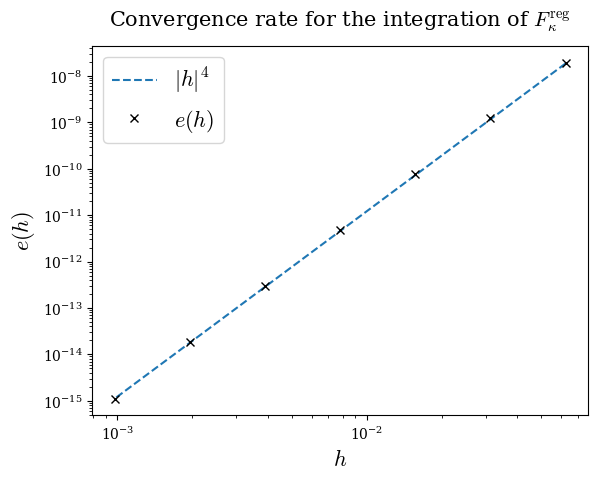

In [221]:
# Convergence of the numerical integration for sigma_cyl_Y(0.56, 2.09)

vi = np.arange(8)
vN = 2**(vi+4)
vh = 1/vN.astype(np.float64)
vcyl = np.zeros_like(vh)

K = 0.56
l = 2.09

for (i,N) in enumerate(vN):
    vcyl[i] = sigma_cyl_Y(K,l,quad_method="simpson", N=N)

precise_value = sigma_cyl_Y(l,K,quad_method="simpson", N=vN[-1]*8)

verror = np.abs(vcyl[1:]-vcyl[:-1])
vh = vh[:-1]

plt.figure(0)
plt.rcParams.update({'mathtext.fontset': "cm", "font.family": "serif"})
plt.loglog(vh, (vh/vh[-1])**4*verror[-1], '--', label='$|h|^4$')
plt.loglog(vh,verror, 'kx', label='$e(h)$')

plt.legend(fontsize=16)
plt.xlabel('$h$',fontsize=16)
plt.ylabel('$e(h)$',fontsize=16)
plt.title("Convergence rate for the integration of $F_\\kappa^{\\mathrm{reg}}$",fontsize=15, pad=14)

plt.savefig("cv_numerical_integration_yukawa.pdf",bbox_inches='tight')
plt.show()

Eventually, we compute and plot $\rho^{3,\mathrm{ball}}_{Y_{1,\kappa}}$ and $\rho^{3,\mathrm{cyl}}_{Y_{1,\kappa}}$ for an interval of $\kappa$ around $0.56$. We use the bound

$$
\rho^{3,\mathrm{cyl}}_{Y_{1,\kappa}} \leq \sigma^{3,\mathrm{cyl}}_{Y_{1,\kappa}}(l(\kappa)),
$$

where adequate $l(\kappa)$ are obtained by minimizing $l\mapsto \sigma^{3,\mathrm{cyl}}_{Y_{1,\kappa}}(l)$ with SciPy's library.

In [20]:
# Plot rho^{ball}_{Y_{1,K}} and Plot rho^{cyl}_{Y_{1,K}} for a range of K

nK = 81
vK = np.linspace(0.56-0.019,0.56+0.03,nK)[::-1]
Kmin = (2*np.pi)**(-1/3)
l_cyl_hint = 1./3
vrho_ball = np.zeros_like(vK)
vrho_cyl = np.zeros_like(vK)
i = 0
while True:
    K = vK[i]
    
    vrho_ball[i], r_ball_opt, success = rho_ball_Y(K)
    
    res_opt = scipy.optimize.minimize(lambda l:  sigma_cyl_Y(K,l,quad_method="scipy"),
                                      l_cyl_hint, tol=1e-13, constraints=[scipy.optimize.LinearConstraint(np.ones(1), lb=0)])
    vrho_cyl[i] = res_opt.fun
    l_cyl_hint = res_opt.x[0]
    
    i += 1
    if i >= nK:
        break


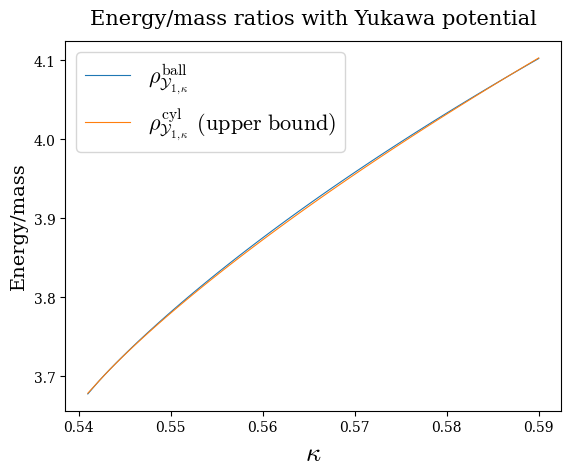

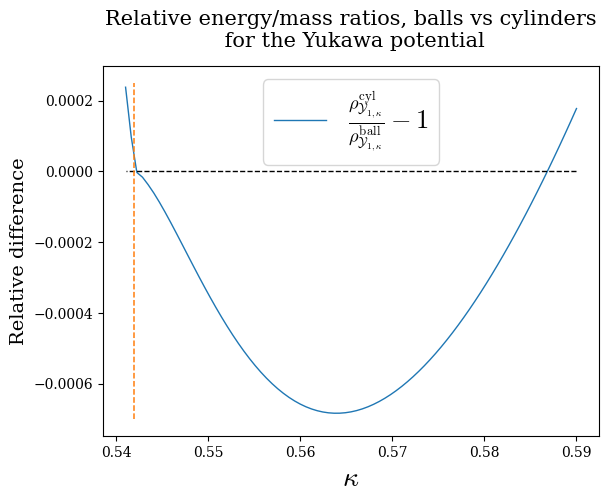

In [21]:
# Plot energy-per-mass
plt.figure(1)
plt.rcParams.update({'mathtext.fontset': "cm", "font.family": "serif"})
plt.plot(vK, vrho_ball, '-', linewidth=.8,label='$\\rho^{\\mathrm{ball}}_{\\mathcal{Y}_{1,\\kappa}}$')
plt.plot(vK, vrho_cyl, '-',linewidth=.8,label='$\\rho^{\\mathrm{cyl}}_{\\mathcal{Y}_{1,\\kappa}}$ $\\mathrm{(upper~bound)}$')
plt.title("Energy/mass ratios with Yukawa potential",fontsize=15, pad=12)
plt.xlabel("$\\kappa$",fontsize=19)
plt.ylabel("Energy/mass",fontsize=14)
plt.legend(fontsize=16)

plt.savefig("energy-per-mass_yukawa.pdf",bbox_inches='tight')

plt.show()

# Plot relative improvement
plt.figure()
plt.rcParams.update({'mathtext.fontset': "cm", "font.family": "serif"})

plt.plot(vK, vrho_cyl/vrho_ball-1, '-', linewidth=1, 
         label="$\\frac{\\rho^{\\mathrm{cyl}}_{\\mathcal{Y}_{1,\\kappa}}}{\\rho^{\\mathrm{ball}}_{\\mathcal{Y}_{1,\\kappa}}}-1$")
plt.plot(vK, np.zeros_like(vK), 'k', linewidth=1, linestyle="dashed" )
vy = np.linspace(-7e-4,2.5e-4,100)
plt.plot(np.full_like(vy,Kmin), vy, linewidth=1.1, linestyle="dashed")

plt.title("Relative energy/mass ratios, balls vs cylinders\n for the Yukawa potential", pad=14, fontsize=15)
plt.xlabel("$\\kappa$", fontsize=20, math_fontfamily='cm')
plt.ylabel("Relative difference",fontsize=14)
plt.legend(fontsize=19,loc='upper center')

plt.savefig("relative_diff_yukawa.pdf",bbox_inches='tight')
plt.show()